In [1]:
from fedhex.utils import print_msg, LOG_WARN
from matplotlib import pyplot as plt
import numpy as np
import os
import re
from typing import Callable
import uproot as up

2023-08-10 23:16:02.191266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_dir = "./root/10x10box_10k_jun2023/"
root_path1 = "./root/10x10box_10k_jun2023/Phi_100_omega_0p25/2023-06-12-11-53-45/v1p0-78-8cf4/ATTOAODv1p2c2_0.root"
root_path2 = "./root/10x10box_10k_jun2023/Phi_3050_omega_5p125/2023-06-12-11-54-17/v1p0-78-8cf4/ATTOAODv1p2c2_0.root"

In [3]:
def _find_root(data_dir, max_depth: int=3):
    p = re.compile(".+\.ROOT$", re.IGNORECASE)
    file_list = []
    with os.scandir(data_dir) as d:
        for entry in d:
            if entry.is_dir():
                if max_depth <= 0:
                    print_msg("Maximum recursion depth reached.", level=LOG_WARN)
                    return file_list
                else:
                    list_subtree = _find_root(data_dir + "/" + entry.name, max_depth=max_depth-1)
                    file_list.extend(list_subtree)
            elif p.match(entry.name) is not None:
                path = data_dir + "/" + entry.name
                if os.stat(path).st_size == 0:
                    print_msg(f"--- {path}: empty file ---", level=LOG_WARN)
                    return []
                return [path + ":Events;1"]
            
    return file_list

In [4]:
up.default_library = "np"
cutstr = "CBL_Region == 1"
phistr = "CBL_RecoPhi_mass"
omegastr = "TwoProng_massPi0"
omegaidxstr = "CBL_RecoPhi_twoprongindex"
ptstr = "Photon_pt"
ptidxstr = "CBL_RecoPhi_photonindex"
labelphistr = "GenPhi_mass"
labelomegastr = "GenOmega_mass"
expressions = [phistr, omegastr, omegaidxstr, ptstr, ptidxstr, labelphistr, labelomegastr]

In [5]:
file_list = _find_root(root_dir)

23:16:09.90 <W> --- ./root/10x10box_10k_jun2023//Phi_1870_omega_9p025/2023-06-
12-11-54-06/v1p0-78-8cf4/ATTOAODv1p2c2_0.root: empty file ---


In [6]:
num_workers = 8
arr = up.concatenate(file_list, expressions=expressions, cut=cutstr, num_workers=num_workers, begin_chunk_size="1KB", library="np")

In [7]:
def _evt_sel_1(arr: np.ndarray, expressions: list[str], cutstr: str, event_thresh: int=100) -> tuple[np.ndarray, np.ndarray]:
    
    # cut out events that don't have a valid omega/pt to index
    omegaidxarr = arr[omegaidxstr]
    ptidxarr = arr[ptidxstr]

    # -1 & -1 == -1 only way to get -1 b/c -1 is all 1 bits
    # idxcutarr = ((omegaidxarr | ptidxarr) != -1)
    idxcutarr = ((omegaidxarr & ptidxarr) != -1)

    # select the events with valid indexes for each variable
    phi = arr[phistr][idxcutarr]
    omega = arr[omegastr][idxcutarr]
    omegaidx = arr[omegaidxstr][idxcutarr]
    pt = arr[ptstr][idxcutarr]
    ptidx = arr[ptidxstr][idxcutarr]
    labelphi = arr[labelphistr][idxcutarr]
    labelomega = arr[labelomegastr][idxcutarr]

    # arrays to store indexed data that satisfy the cut
    omega_temp = np.empty_like(omega, dtype=np.float32)
    labelphi_temp = np.empty_like(labelphi, dtype=np.float32)
    labelomega_temp = np.empty_like(labelomega, dtype=np.float32)

    # perform cut and extract correct element with index
    for i in range(len(omega)):
        if pt[i][ptidx[i]] > 220:
            omega_temp[i] = omega[i][omegaidx[i]]
            labelphi_temp[i] = labelphi[i][0]
            labelomega_temp[i] = labelomega[i][0]
        else:
            omega_temp[i] = np.nan

    # copy only the events that satisfy the cut
    cutarr = np.isfinite(omega_temp)
    newphi = phi[cutarr].copy()
    newomega = omega_temp[cutarr].copy()
    newlabelphi = labelphi_temp[cutarr].copy()
    newlabelomega = labelomega_temp[cutarr].copy()

    samples = np.stack((newphi, newomega), axis=1)
    labels = np.stack((newlabelphi, newlabelomega), axis=1)

    return samples, labels

In [21]:
def _load_root(root_paths, event_selection_fn: Callable, expressions: list[str], cutstr: str, event_thresh: int=100):
    
        
    num_workers = 4
    arr = up.concatenate(root_paths, expressions=expressions, cut=cutstr, num_workers=num_workers, begin_chunk_size="2 MB", library="np")

    samples_temp, labels_temp = event_selection_fn(arr, expressions=expressions, cutstr=cutstr)

    # separate samples/labels into groups per label
    labels_unique, inverse_unique = np.unique(labels_temp, return_inverse=True, axis=0)
    samples_grp = [samples_temp[inverse_unique == i] for i in range(len(labels_unique))]

    # compile samples and labels array
    samples = np.zeros(shape=(0, samples_temp.shape[-1]))
    labels = np.zeros(shape=(0, labels_temp.shape[-1]))

    for i, sample_i in enumerate(samples_grp):
        label_i = labels_unique[i]
        # only include data from labels with sufficiently many statistics after cuts
        if len(sample_i) >= event_thresh:
            samples = np.r_[samples, sample_i]
            labels = np.r_[labels, np.repeat([label_i], len(sample_i), axis=0)]

    return samples, labels

In [22]:
event_thresh = 100
s, l = _load_root(file_list, _evt_sel_1, expressions=expressions, cutstr=cutstr, event_thresh=event_thresh)

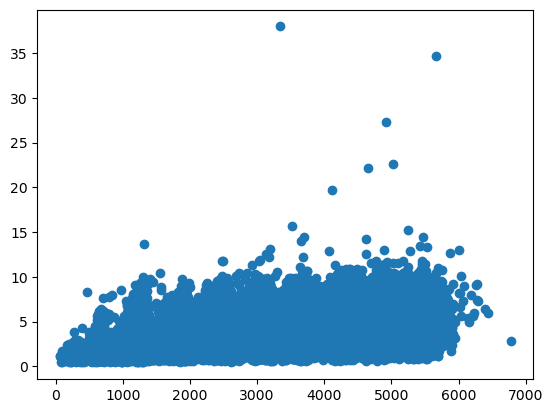

In [23]:
plt.scatter(s[:, 0], s[:, 1])

In [25]:
print(l.shape)

(47665, 2)


In [26]:
labels_unique, inverse_unique = np.unique(l, return_inverse=True, axis=0)
print(l.shape)

(47665, 2)


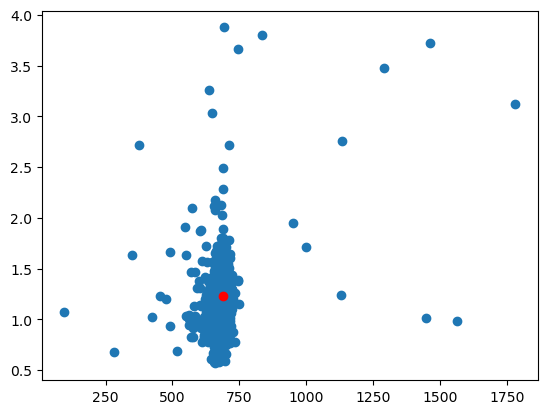

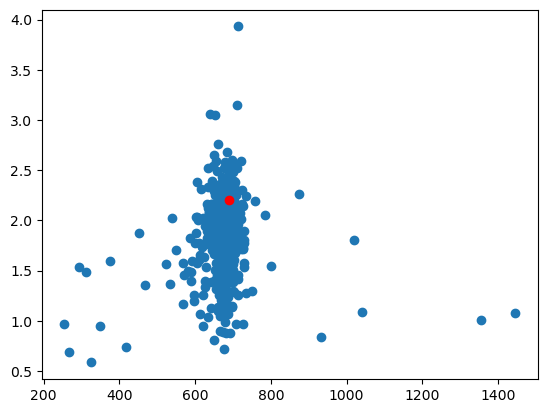

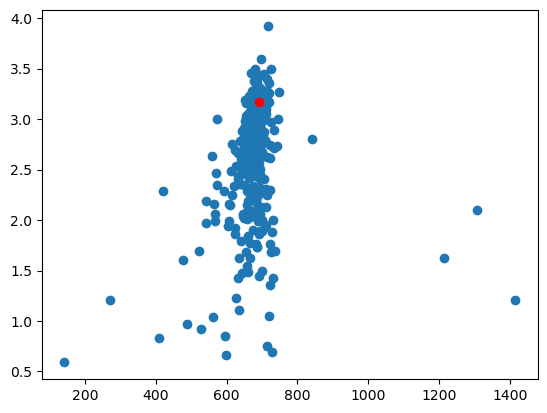

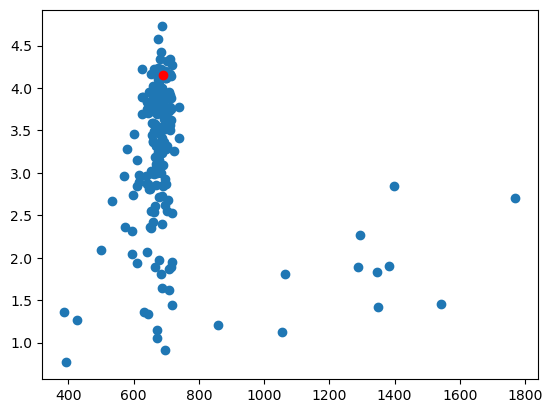

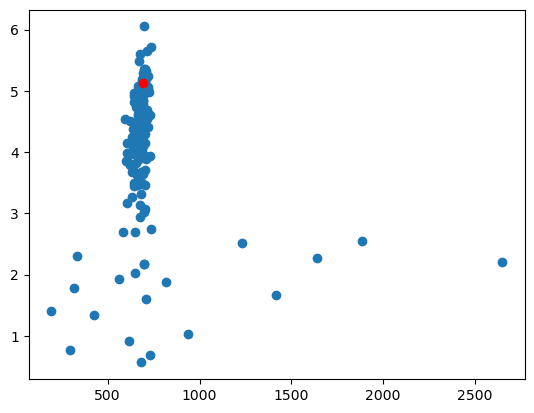

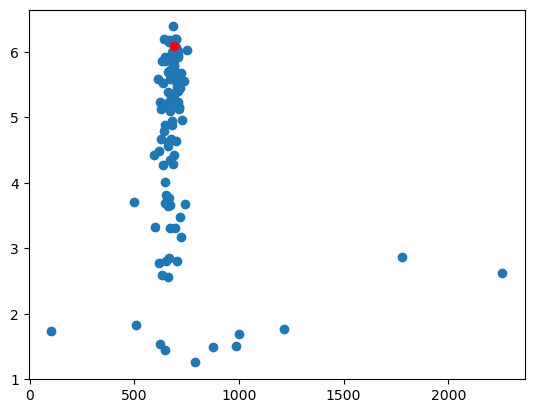

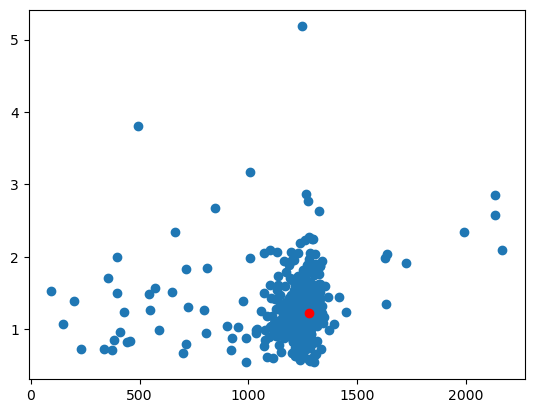

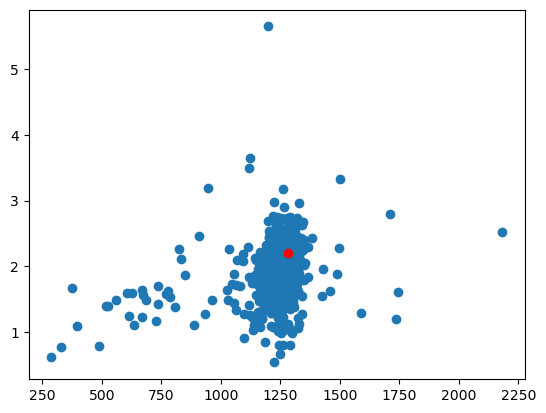

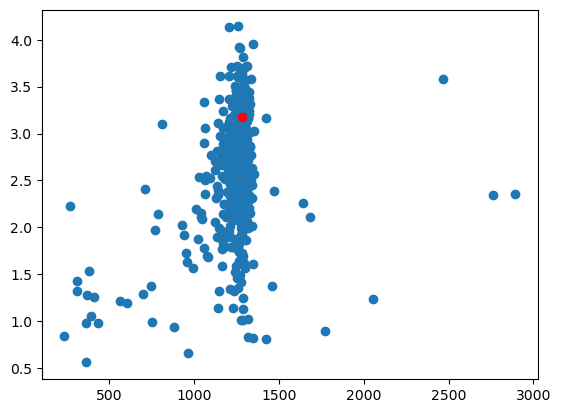

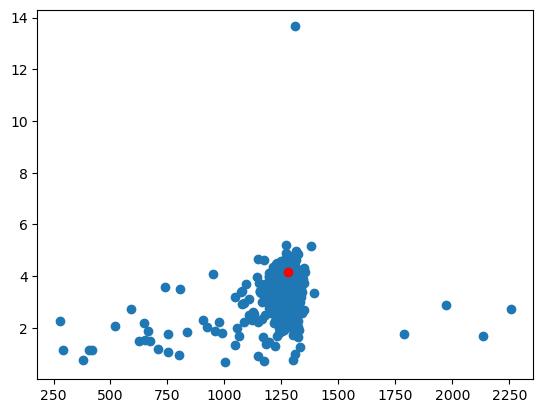

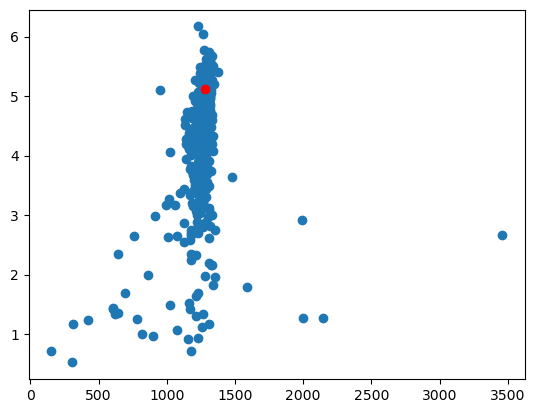

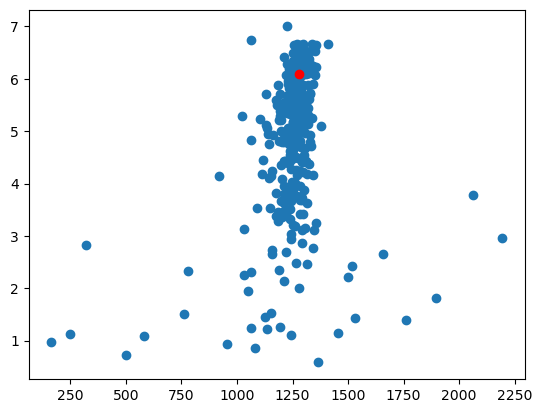

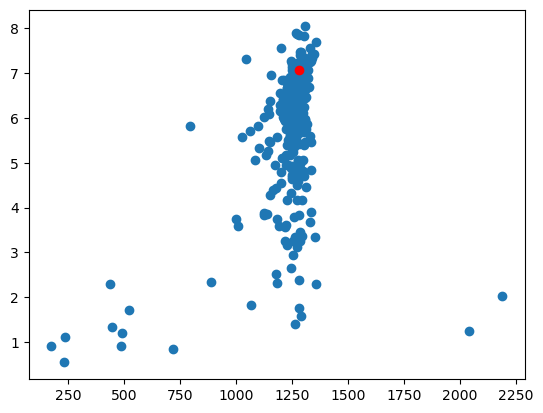

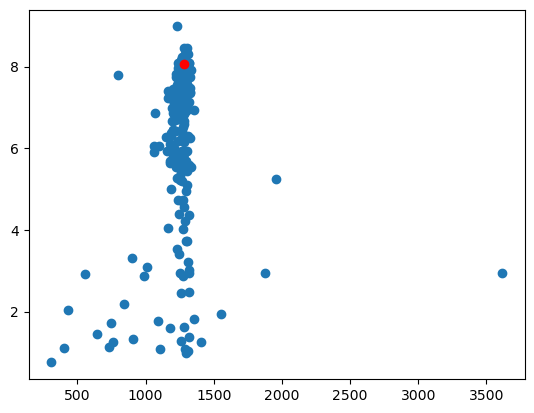

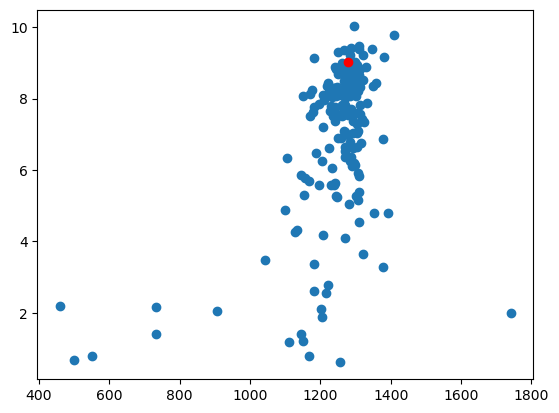

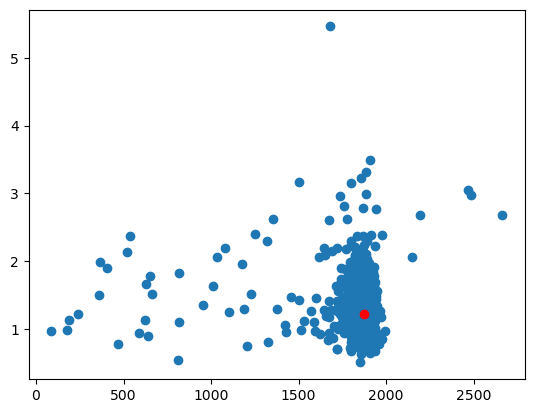

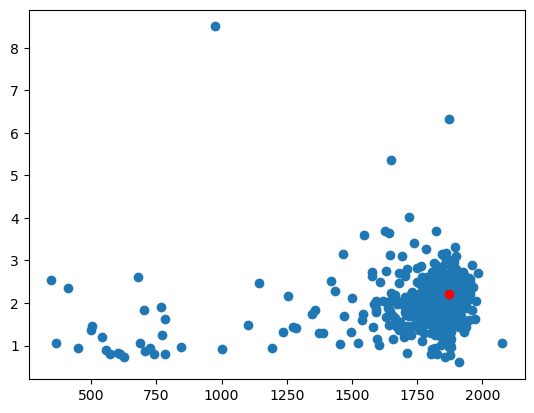

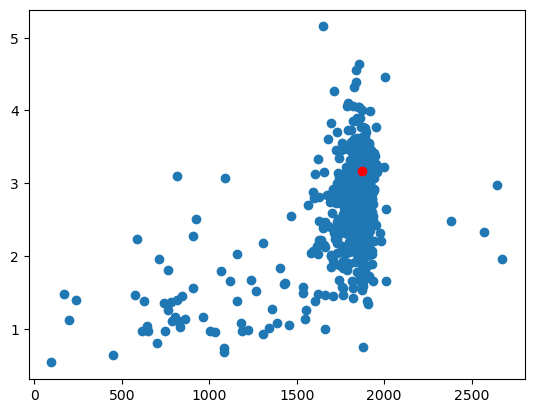

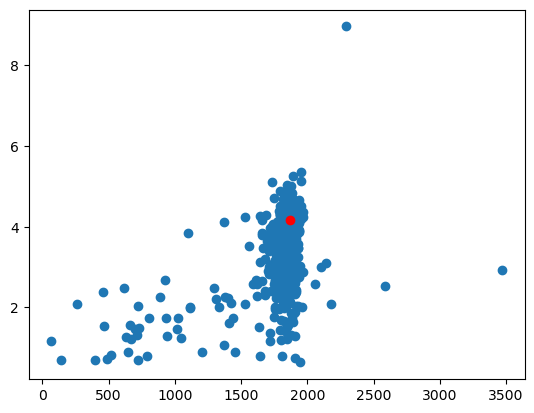

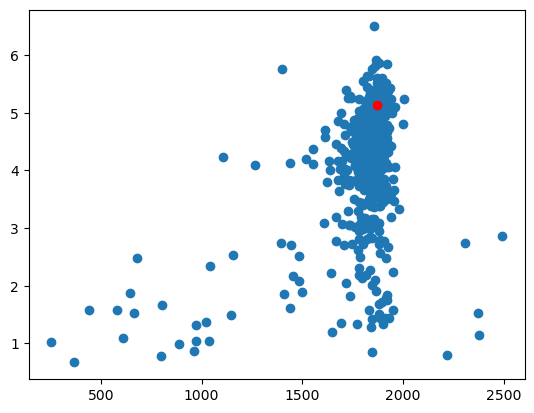

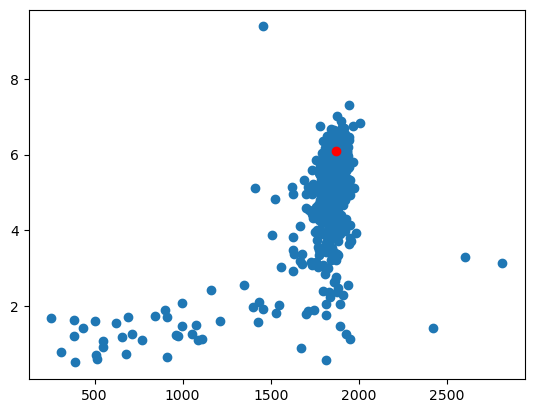

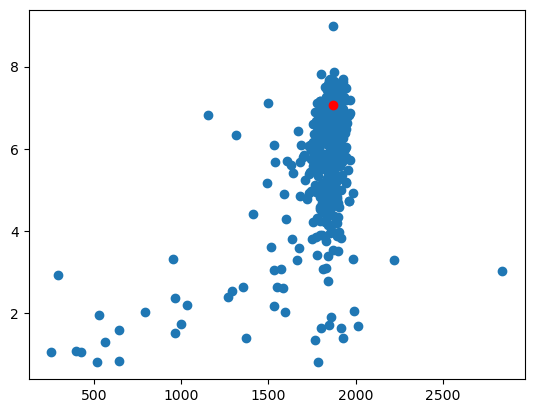

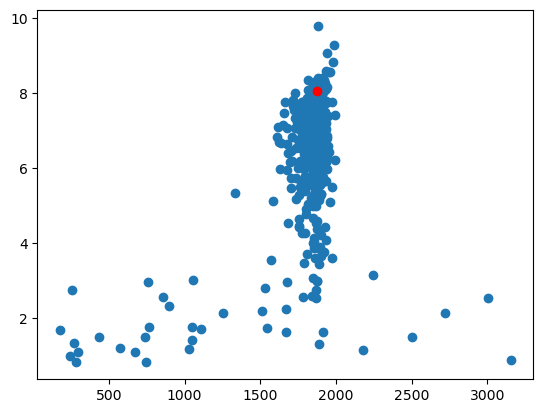

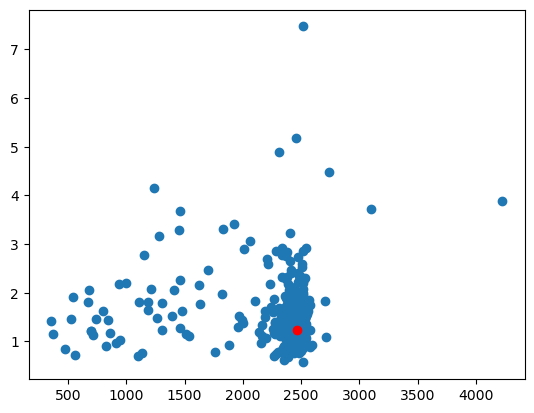

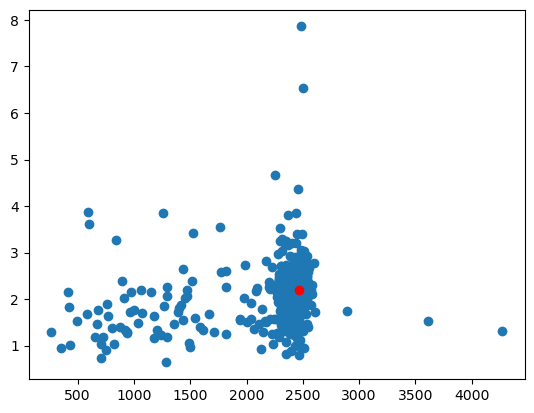

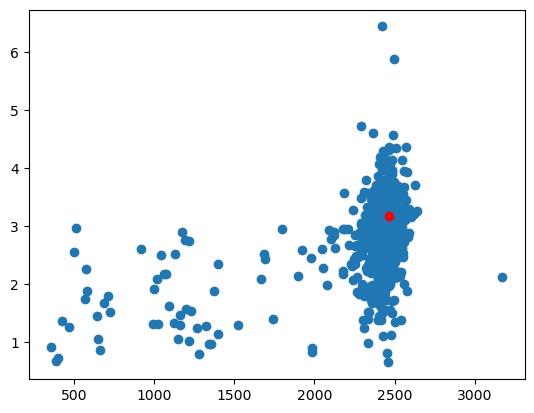

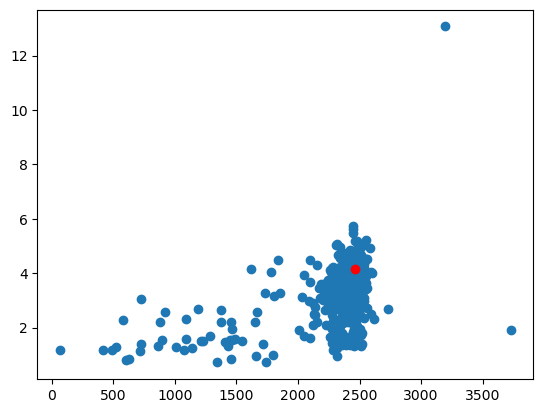

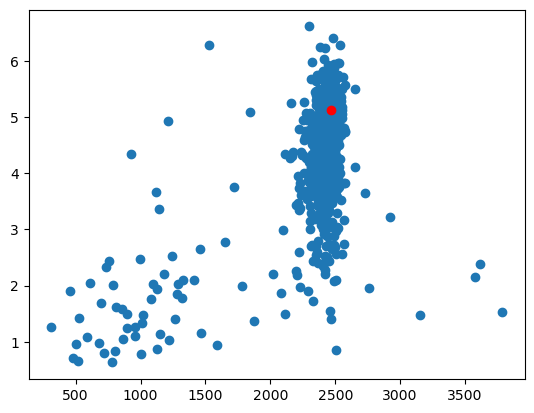

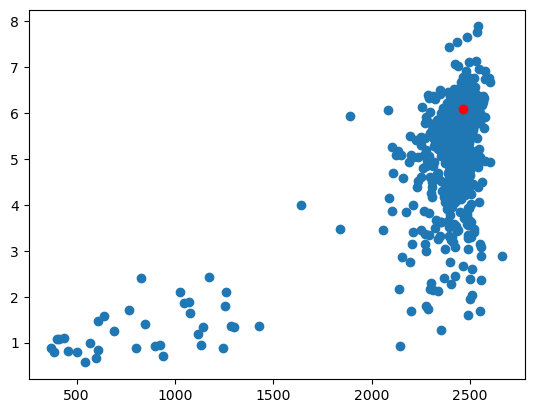

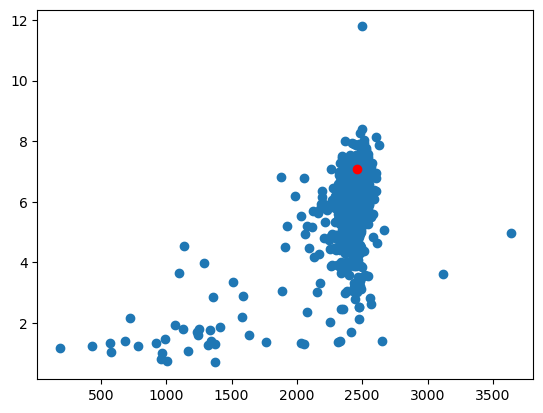

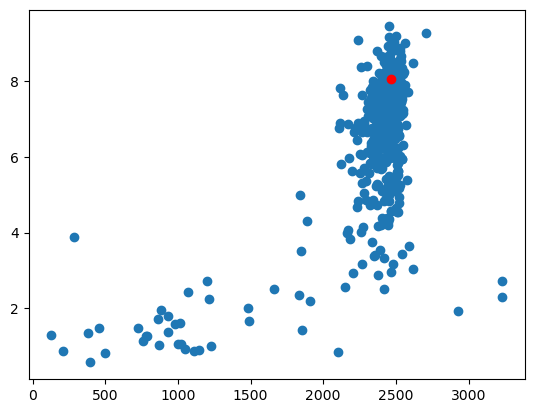

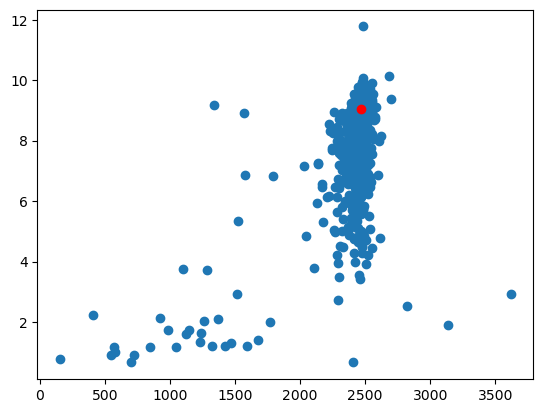

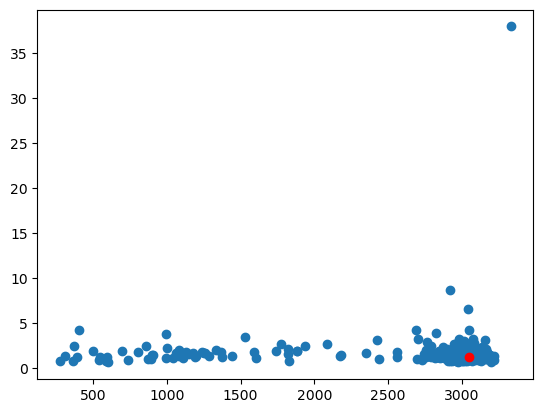

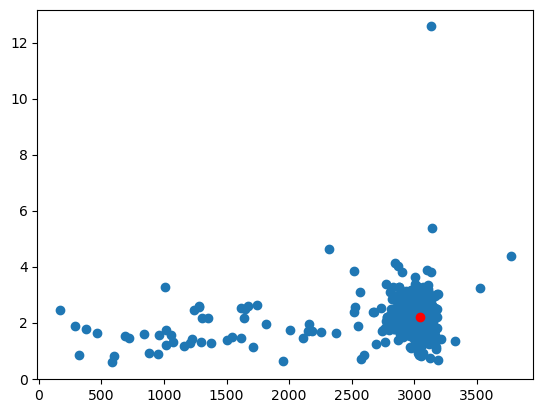

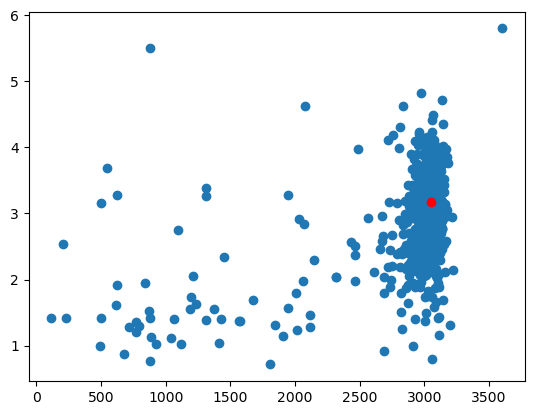

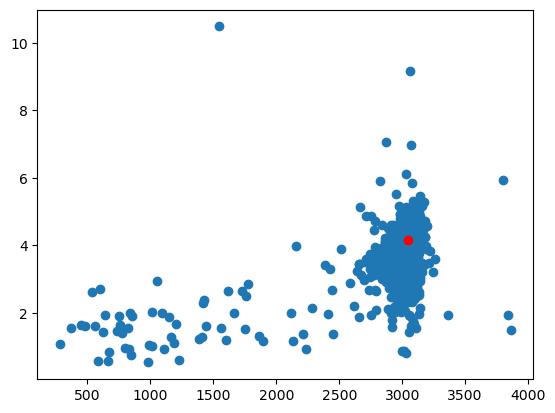

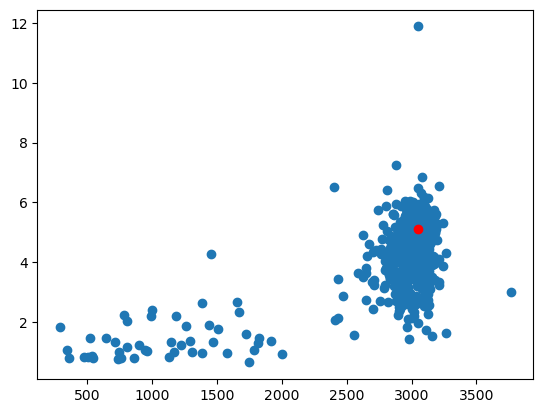

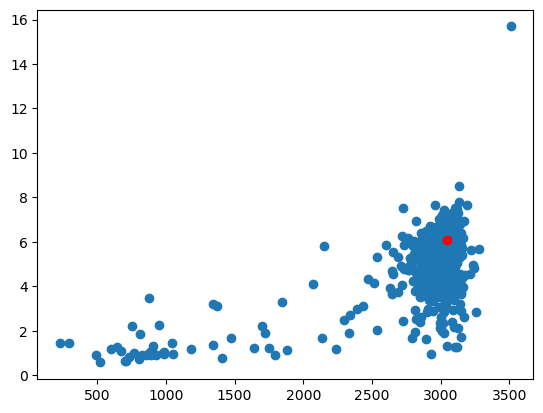

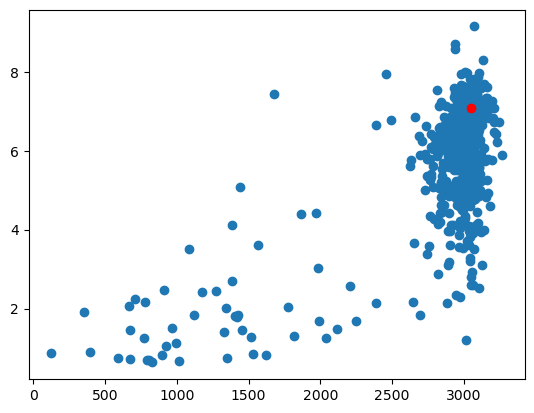

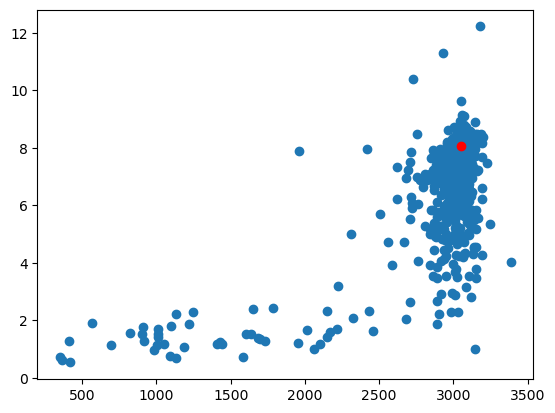

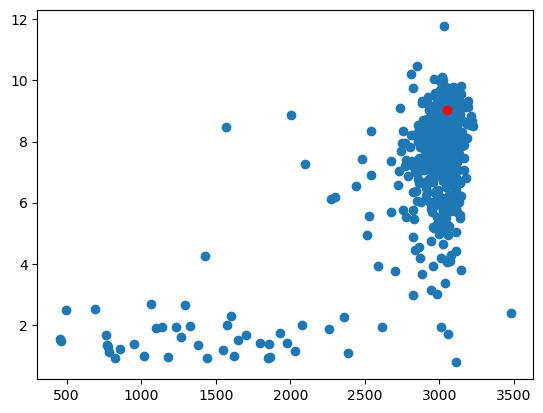

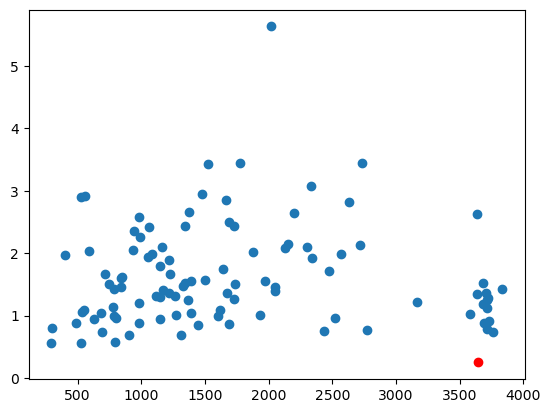

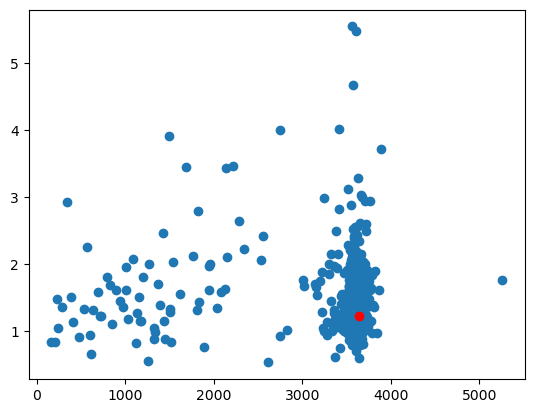

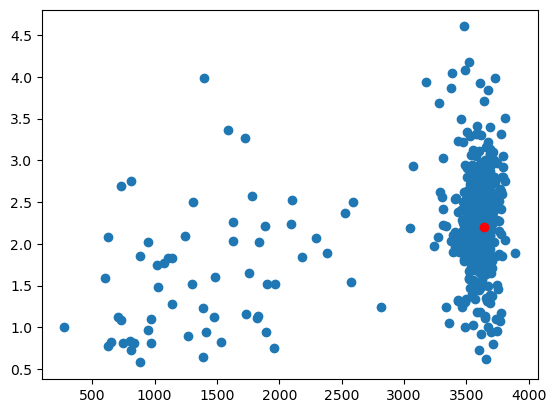

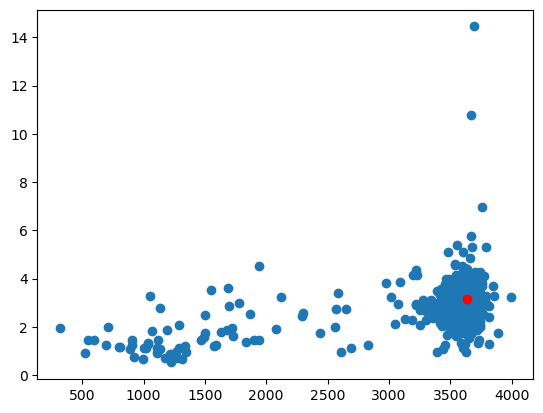

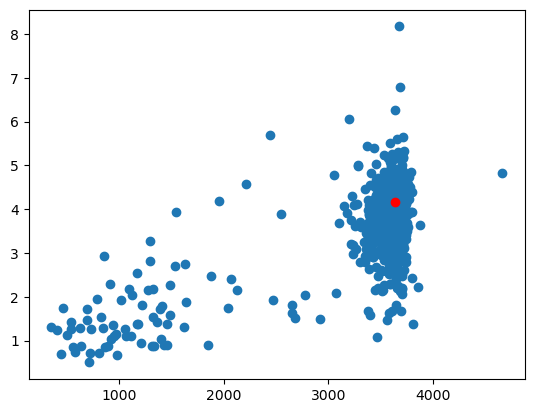

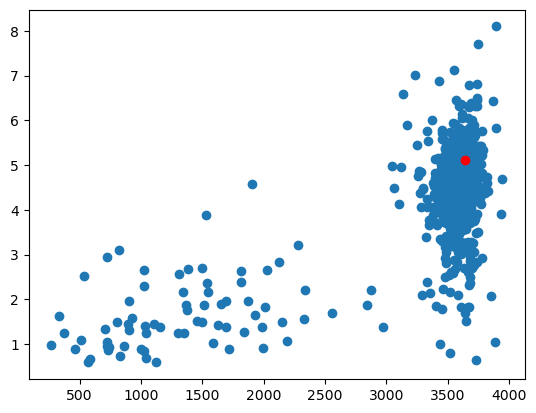

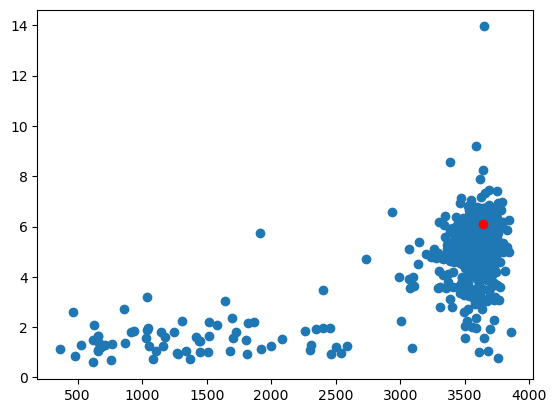

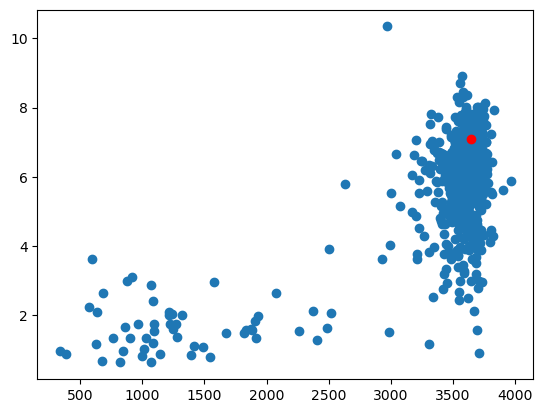

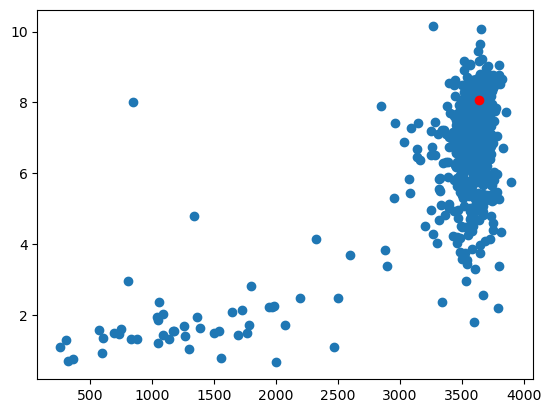

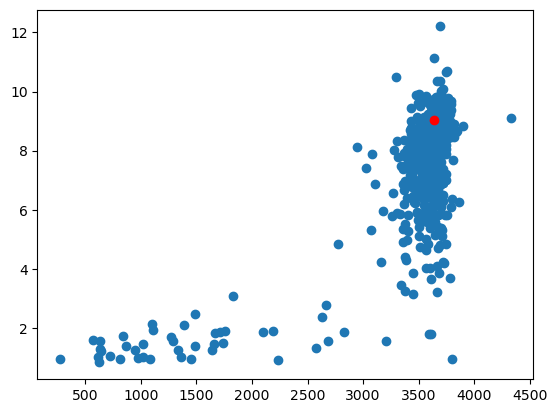

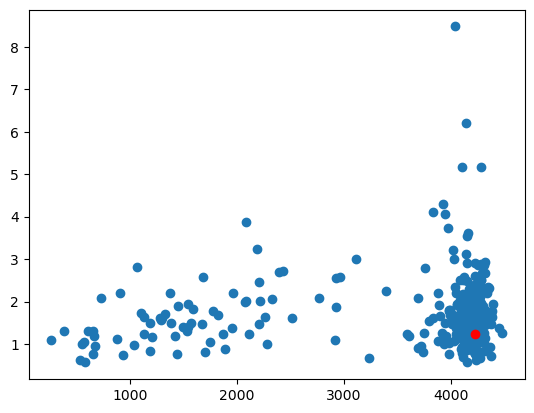

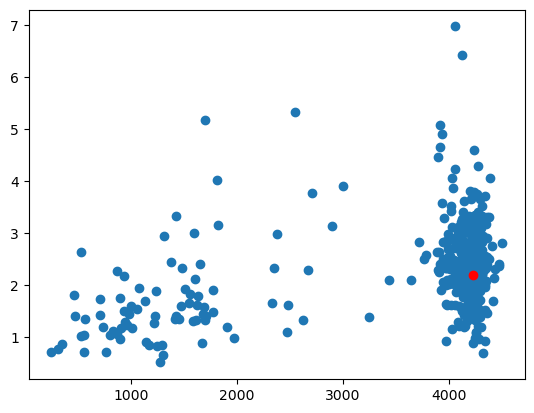

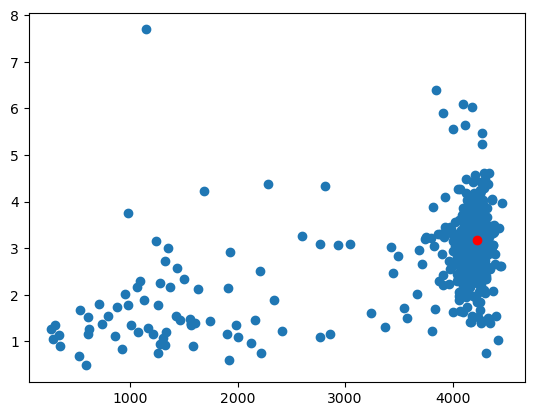

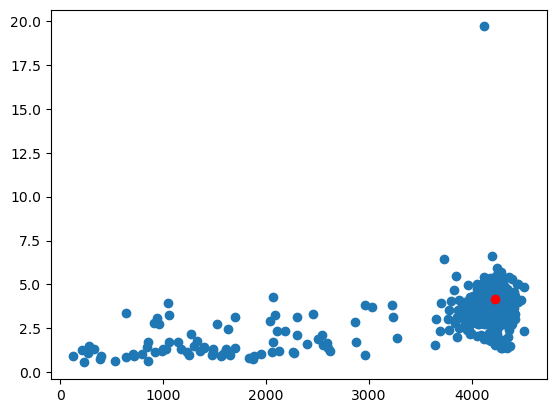

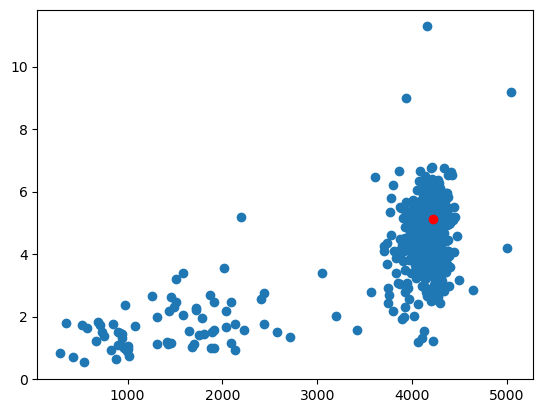

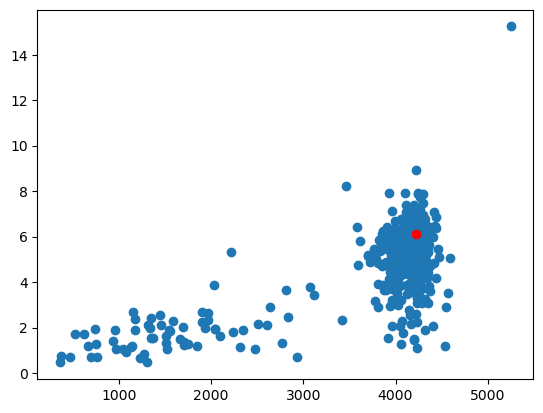

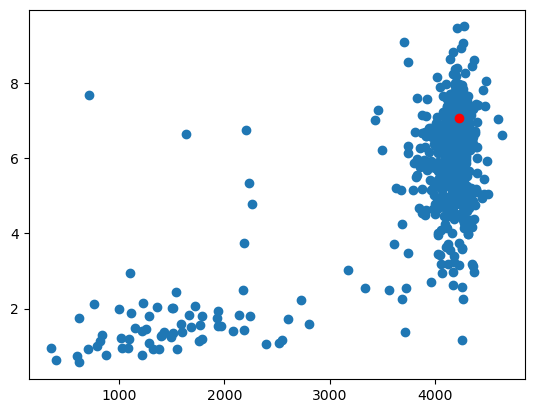

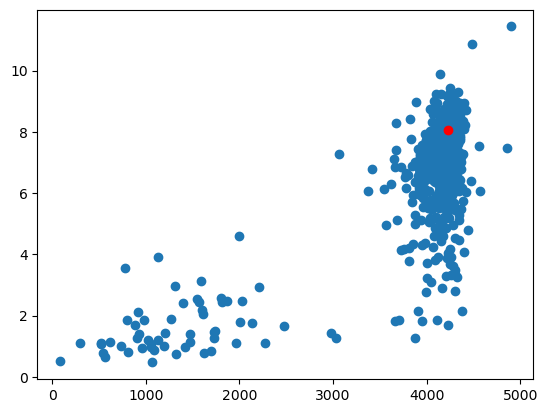

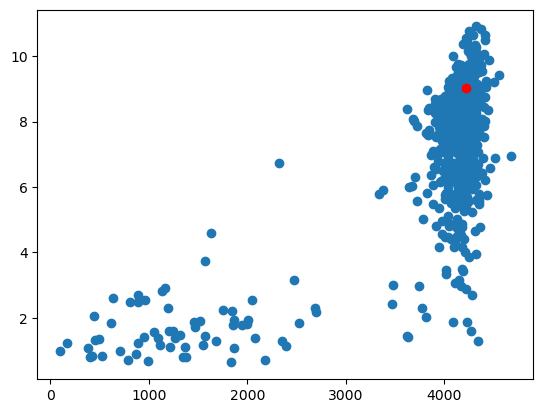

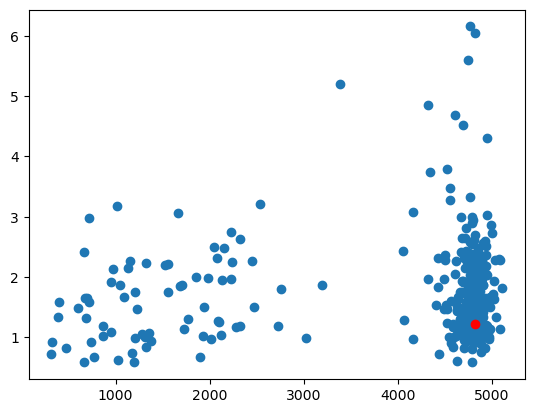

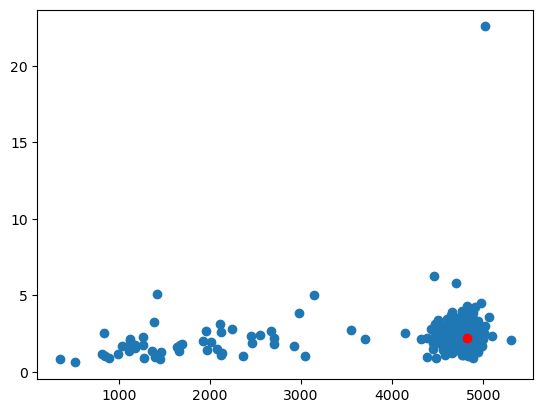

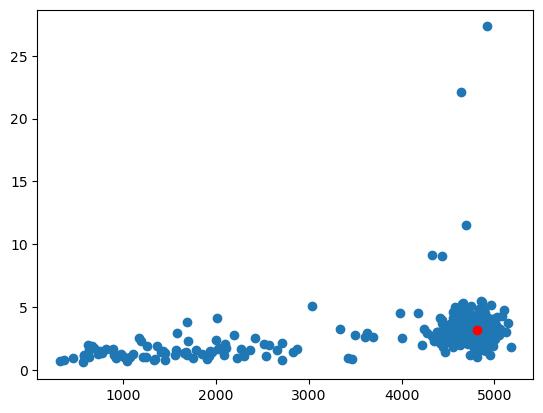

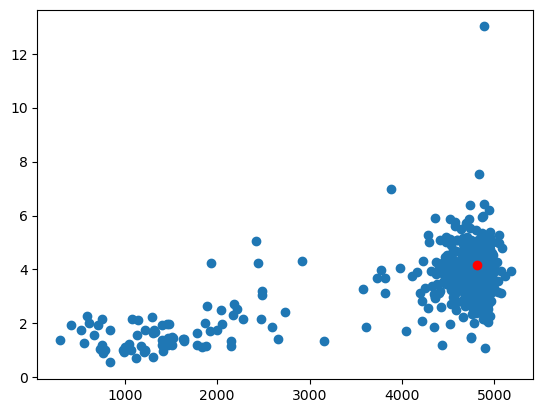

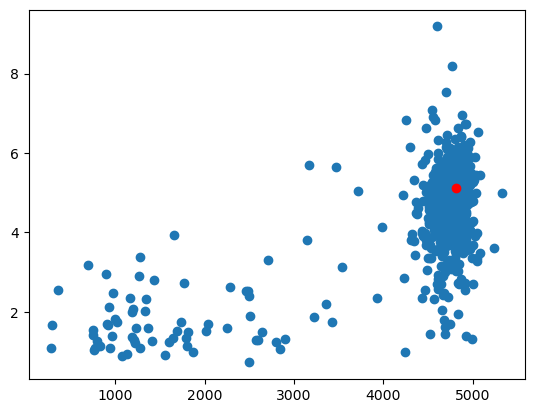

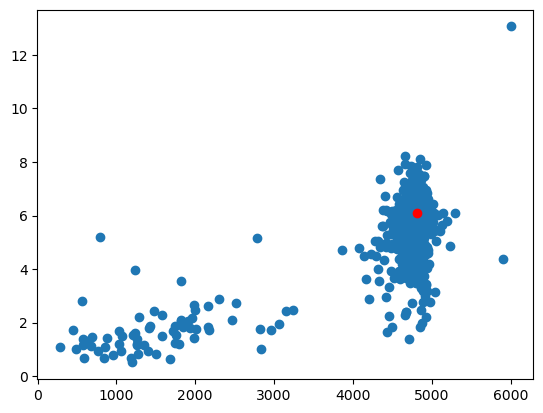

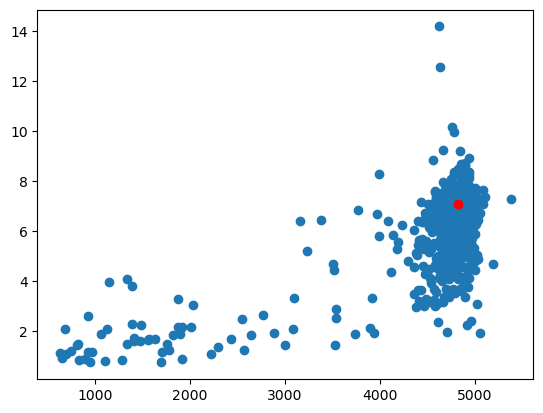

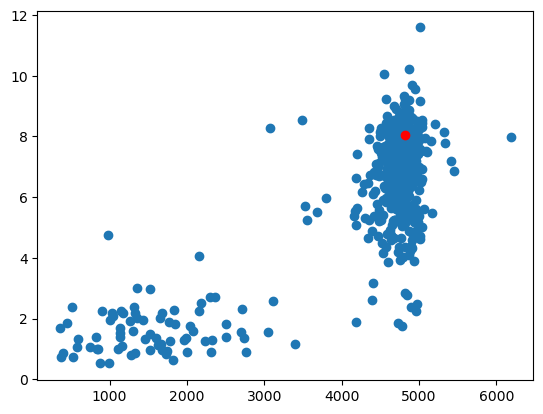

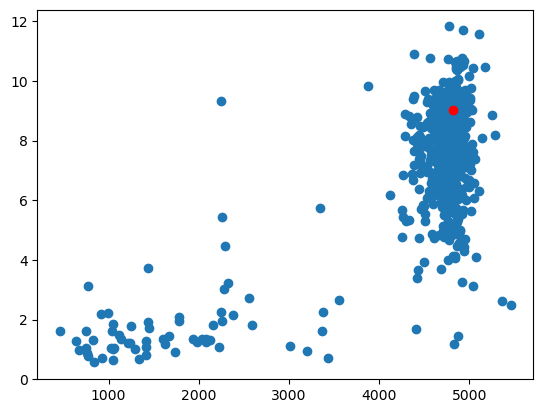

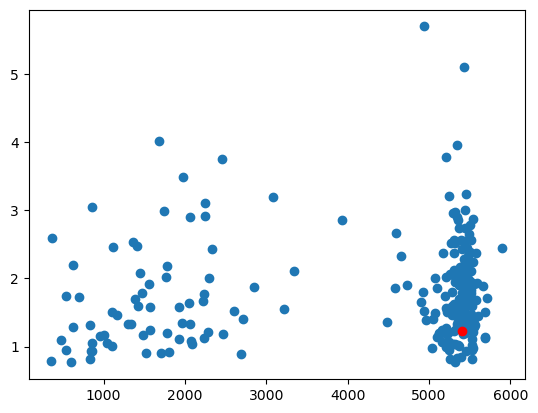

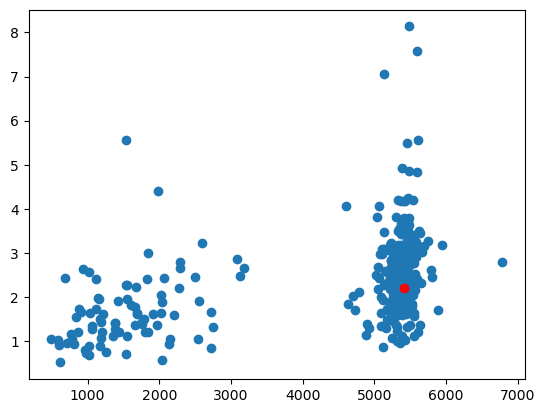

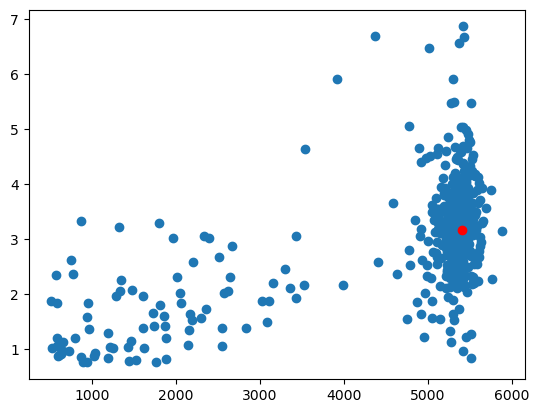

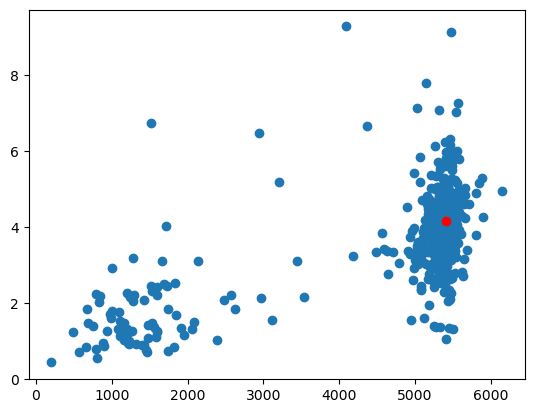

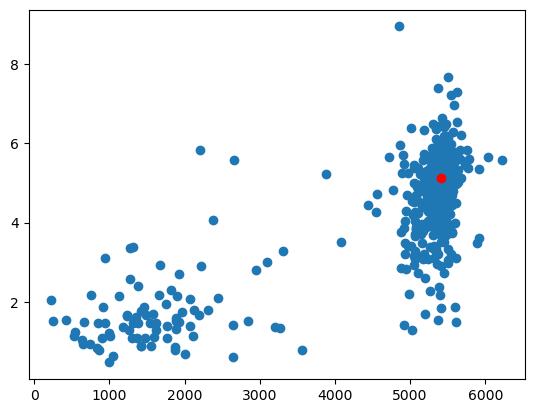

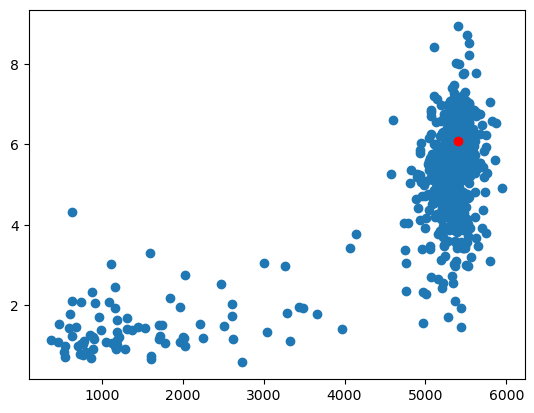

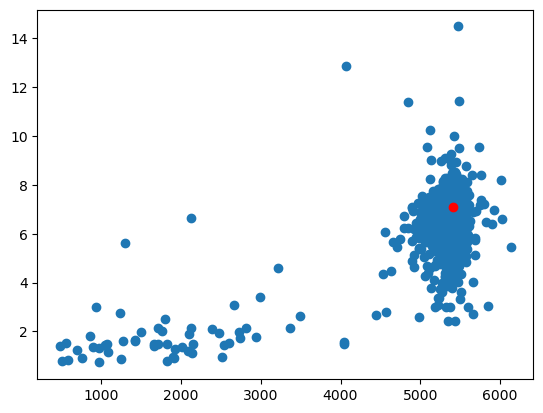

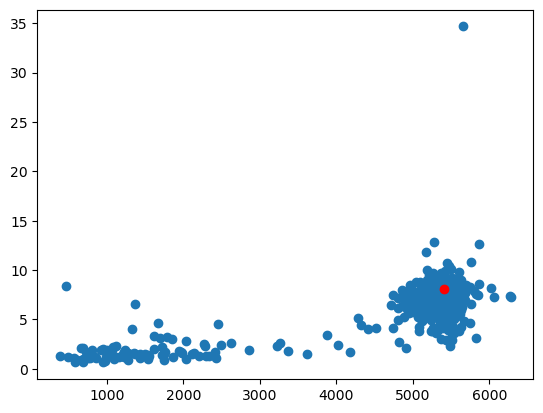

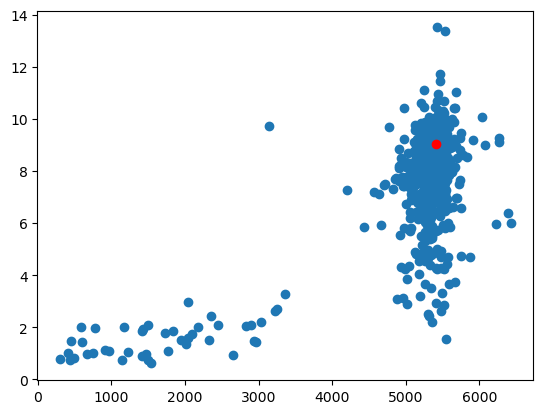

In [27]:
# separate samples/labels into groups per label
labels_unique, inverse_unique = np.unique(l, return_inverse=True, axis=0)
samples_grp = [s[inverse_unique == i] for i in range(len(labels_unique))]

for i, sample_i in enumerate(samples_grp):
    label_i = labels_unique[i]
    # only include data from labels with sufficiently many statistics after cuts
    if len(sample_i) >= event_thresh:
        plt.close()
        plt.scatter(sample_i[:, 0], sample_i[:, 1])
        plt.scatter(label_i[0], label_i[1], c="red")
        plt.show()